In [1]:
import pandas as pd
import statsmodels.api as sm

df = pd.read_csv("C:/Users/secar/OneDrive/Documents/UCLA/Empirical Methods/ForecastingData.csv")

df["date"] = pd.to_datetime(df["caldt"].astype(str), format="%Y%m%d")

sample = df[(df["date"] >= "1967-01-01") & (df["date"] <= "2022-12-31")].copy()

cols = ["ExcessRet", "l.cpi", "l.dp_adj", "l.y10minFF"]
sample = sample[["date"] + cols].dropna()

print(sample.head())
print(sample.tail())
print("N =", len(sample))

         date  ExcessRet    l.cpi  l.dp_adj  l.y10minFF
48 1967-01-31   0.078149  0.00000  0.148263     -0.0036
49 1967-02-28   0.007150  0.00000  0.152243      0.0052
50 1967-03-31   0.038783  0.00000  0.060992     -0.0003
51 1967-04-28   0.037428  0.00304  0.048677      0.0000
52 1967-05-31  -0.043207  0.00303  0.003264      0.0078
          date  ExcessRet     l.cpi  l.dp_adj  l.y10minFF
715 2022-08-31  -0.038968 -0.000118  0.113258      0.0035
716 2022-09-30  -0.098528 -0.000354  0.036646      0.0082
717 2022-10-31   0.073413  0.002151  0.091600      0.0075
718 2022-11-30   0.047313  0.004056  0.194720      0.0102
719 2022-12-30  -0.063883 -0.001010  0.131577     -0.0015
N = 672


In [2]:
y = sample["ExcessRet"]
X = sample[["l.cpi", "l.dp_adj", "l.y10minFF"]]
X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:              ExcessRet   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.904
Date:                Mon, 16 Feb 2026   Prob (F-statistic):             0.0341
Time:                        19:17:46   Log-Likelihood:                 1117.0
No. Observations:                 672   AIC:                            -2226.
Df Residuals:                     668   BIC:                            -2208.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.003      2.001      0.0

In [3]:
nw12 = ols.get_robustcov_results(cov_type="HAC", maxlags=12)
print(nw12.summary())

                            OLS Regression Results                            
Dep. Variable:              ExcessRet   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.183
Date:                Mon, 16 Feb 2026   Prob (F-statistic):              0.315
Time:                        19:18:02   Log-Likelihood:                 1117.0
No. Observations:                 672   AIC:                            -2226.
Df Residuals:                     668   BIC:                            -2208.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.004      1.394      0.1

In [4]:
out = pd.DataFrame({
    "coef": nw12.params,
    "tstat (NW12)": nw12.tvalues,
    "pval (NW12)": nw12.pvalues
})
print(out)
print("R2 =", float(nw12.rsquared))

       coef  tstat (NW12)  pval (NW12)
0  0.005793      1.394152     0.163735
1 -0.754738     -1.094350     0.274196
2  0.020079      1.384601     0.166637
3  0.144167      1.009883     0.312917
R2 = 0.012875355182527914


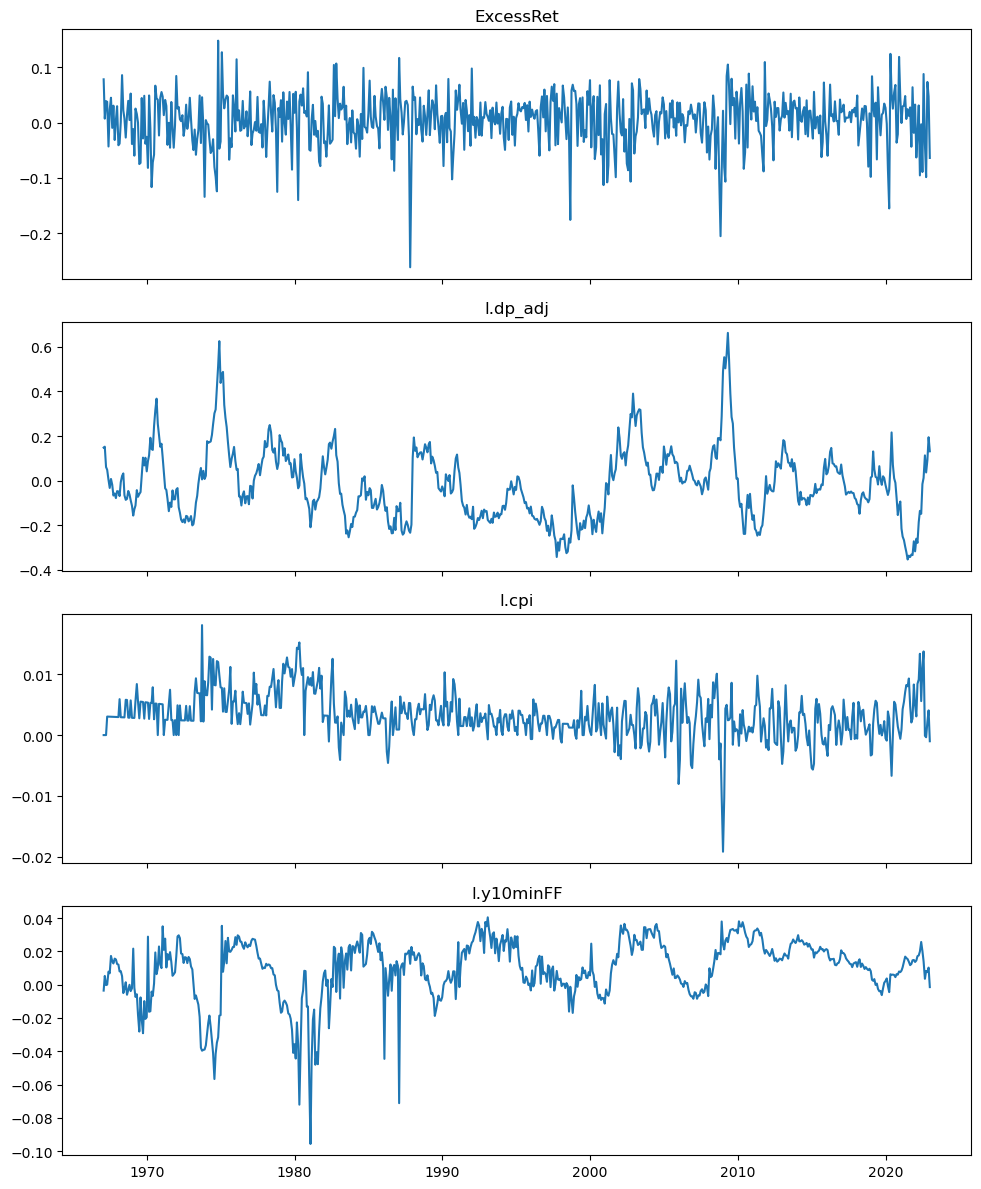

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

series = ["ExcessRet", "l.dp_adj", "l.cpi", "l.y10minFF"]

for ax, var in zip(axes, series):
    ax.plot(sample["date"], sample[var])
    ax.set_title(var)

plt.tight_layout()
plt.show()

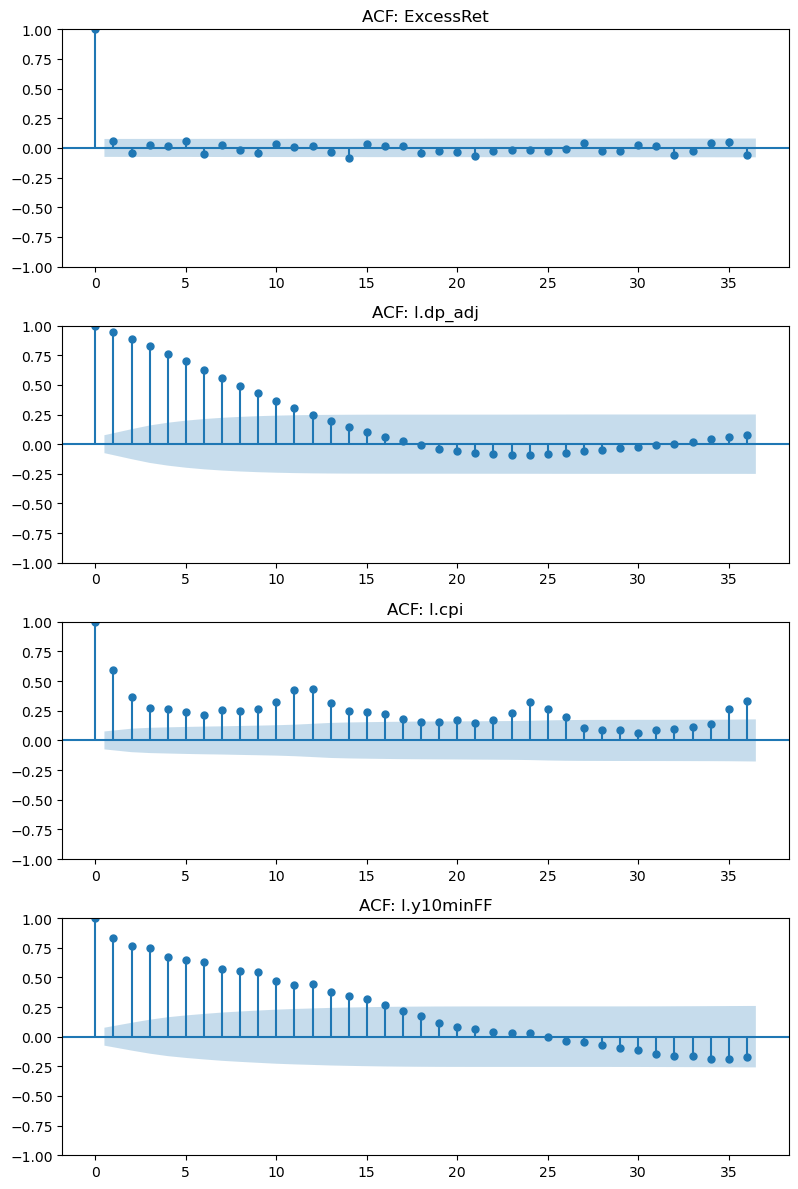

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(4, 1, figsize=(8, 12))

for ax, var in zip(axes, series):
    plot_acf(sample[var], ax=ax, lags=36)
    ax.set_title(f"ACF: {var}")

plt.tight_layout()
plt.show()

In [7]:
import numpy as np

sample["ExcessRet_12m"] = sample["ExcessRet"].rolling(12).sum().shift(-11)
sample = sample.dropna()

In [8]:
y = sample["ExcessRet_12m"]
X = sample[["l.cpi", "l.dp_adj", "l.y10minFF"]]
X = sm.add_constant(X)

ols_12 = sm.OLS(y, X).fit()

In [9]:
#Newey West
nw12 = ols_12.get_robustcov_results(cov_type="HAC", maxlags=11)
print(nw12.summary())

                            OLS Regression Results                            
Dep. Variable:          ExcessRet_12m   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     7.516
Date:                Mon, 16 Feb 2026   Prob (F-statistic):           5.97e-05
Time:                        19:37:11   Log-Likelihood:                 293.98
No. Observations:                 661   AIC:                            -580.0
Df Residuals:                     657   BIC:                            -562.0
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0582      0.024      2.391      0.0

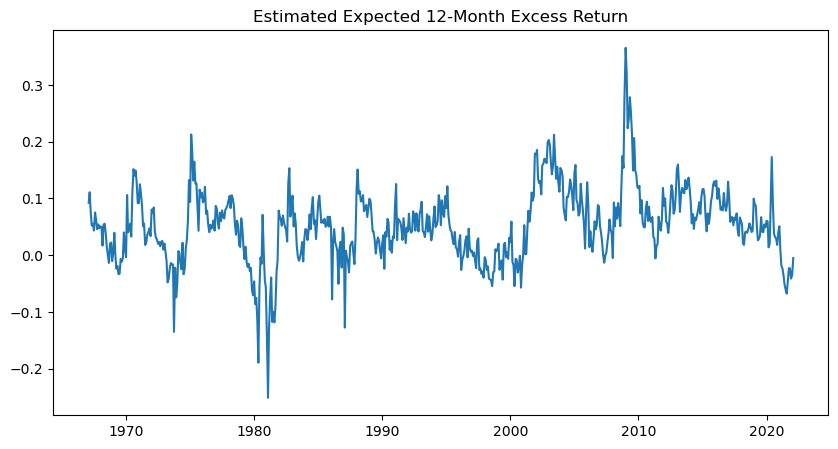

In [10]:
sample["Expected_12m"] = X @ nw12.params

plt.figure(figsize=(10,5))
plt.plot(sample["date"], sample["Expected_12m"])
plt.title("Estimated Expected 12-Month Excess Return")
plt.show()

In [11]:
import numpy as np
import pandas as pd

sample["mu_12m"] = (X @ nw12.params)

dec = sample[sample["date"].dt.month == 12].copy()

dec["mkt_12m"] = dec["ExcessRet_12m"]
dec["strat_12m"] = dec["mu_12m"] * dec["mkt_12m"]   # ω_t = μ_t

def sharpe(x):
    x = x.dropna()
    return x.mean() / x.std(ddof=1)

sr_bh = sharpe(dec["mkt_12m"])
sr_strat = sharpe(dec["strat_12m"])

print("Buy&Hold Sharpe (annual):", sr_bh)
print("Timing strategy Sharpe (annual):", sr_strat)

print(dec[["mkt_12m","mu_12m","strat_12m"]].describe())

Buy&Hold Sharpe (annual): 0.30415211560040484
Timing strategy Sharpe (annual): 0.5663389588119306
         mkt_12m     mu_12m  strat_12m
count  55.000000  55.000000  55.000000
mean    0.051104   0.069902   0.009459
std     0.168023   0.073729   0.016702
min    -0.526567  -0.146688  -0.031427
25%    -0.032109   0.022849   0.000484
50%     0.109820   0.067971   0.007235
75%     0.164899   0.102329   0.015382
max     0.266663   0.365527   0.097473
